# Modelling

We first just run the whole Model Pipeline available in 003, 004 and 005

## 1. Data Import

In [1]:
source('../trunk/progs/001-Data_Import.R')

Lade nötiges Paket: farff

Parse with reader=readr : ../trunk/data/freMTPL2freq.arff

Lade nötiges Paket: readr

header: 0.010000; preproc: 0.277000; data: 0.888000; postproc: 0.040000; total: 1.215000

Parse with reader=readr : ../trunk/data/freMTPL2sev.arff

header: 0.002000; preproc: 0.007000; data: 0.011000; postproc: 0.000000; total: 0.020000



## 2. Feature Engineering and Data Preparation Steps

In [2]:
source('../trunk/progs/002-FeatEng_Prep.R')

## 3. Data Split

Here we Split it 80%, 10%, 10%, so that we have a training set to train the models in both Stages,
then test to validate the models on the Stages, and a validation for when we have the final 
results


In [3]:
source('../trunk/progs/003-Data_Split.R')

Lade nötiges Paket: caret

Lade nötiges Paket: ggplot2

Lade nötiges Paket: lattice



In [4]:
str(m2_train)

'data.frame':	542411 obs. of  15 variables:
 $ IDpol     : num  1 3 5 10 11 15 17 18 21 27 ...
 $ ClaimNb   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Exposure  : num  0.1 0.77 0.75 0.09 0.84 0.45 0.27 0.71 0.15 0.87 ...
 $ Area      : Factor w/ 6 levels "A","B","C","D",..: 4 4 2 2 2 5 3 3 2 3 ...
 $ VehPower  : Factor w/ 6 levels "4","5","6","7",..: 2 2 3 4 4 3 4 4 4 4 ...
 $ VehAge    : Ord.factor w/ 5 levels "[0,2]"<"(2,5]"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ DrivAge   : Ord.factor w/ 5 levels "[18,25]"<"(25,35]"<..: 4 4 4 4 4 3 2 2 3 5 ...
 $ BonusMalus: int  50 50 50 50 50 50 68 68 50 50 ...
 $ VehBrand  : Factor w/ 11 levels "B1","B10","B11",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ VehGas    : Factor w/ 2 levels "Diesel","Regular": 2 2 1 1 1 2 1 1 1 1 ...
 $ Density   : Ord.factor w/ 5 levels "[0,100]"<"(100,200]"<..: 5 5 1 1 1 5 2 2 1 2 ...
 $ Region    : Factor w/ 22 levels "R11","R21","R22",..: 18 18 3 15 15 8 20 20 12 21 ...
 $ Claim     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ sumClaims : num  NA NA NA NA

# Model Stage 1

## Classifier
We will train a classifier first (logistic regression). To see how well we
can identify the Claims.


In [4]:
glm1 <- glm(Claim ~ VehPower + VehAge + DrivAge + BonusMalus
                        + VehBrand + VehGas + Density + Region + Area,
                data=m2_train, offset=log(Exposure), family=binomial())


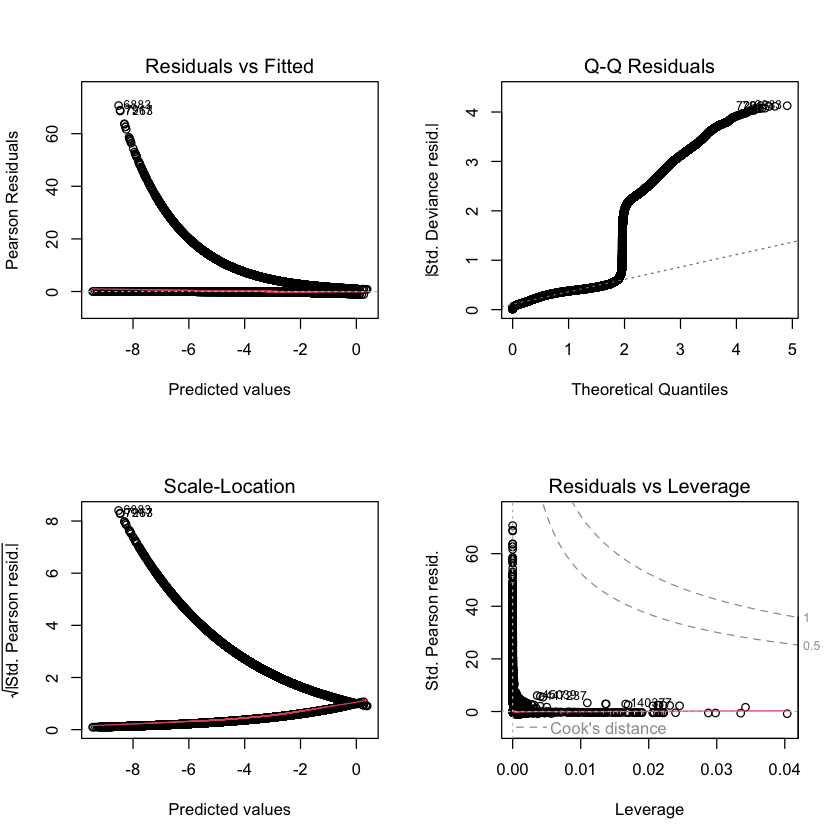

In [9]:
par(mfrow=c(2,2))
plot(glm1)

In [5]:
summary(glm1)


Call:
glm(formula = Claim ~ VehPower + VehAge + DrivAge + BonusMalus + 
    VehBrand + VehGas + Density + Region + Area, family = binomial(), 
    data = m2_train, offset = log(Exposure))

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -4.8813042  0.3446758 -14.162  < 2e-16 ***
VehPower5      0.1957827  0.0219062   8.937  < 2e-16 ***
VehPower6      0.2083687  0.0218361   9.542  < 2e-16 ***
VehPower7      0.1347867  0.0215077   6.267 3.68e-10 ***
VehPower8     -0.0740735  0.0325252  -2.277 0.022761 *  
VehPower9      0.2325183  0.0240748   9.658  < 2e-16 ***
VehAge.L      -0.5157825  0.0212045 -24.324  < 2e-16 ***
VehAge.Q      -0.0134003  0.0181205  -0.740 0.459598    
VehAge.C      -0.1573222  0.0160124  -9.825  < 2e-16 ***
VehAge^4       0.0966439  0.0136223   7.095 1.30e-12 ***
DrivAge.L      0.2699843  0.0217537  12.411  < 2e-16 ***
DrivAge.Q     -0.0135930  0.0174959  -0.777 0.437204    
DrivAge.C     -0.2162585  0.0148007 -14.611  < 2e-16 **

## Evaluation of Results Based on Classifier Metrics



In [6]:
source('../trunk/progs/util_funcs.R')
glm1_pred <- predict(glm1, newdata=m2_test, type="response")
evalCut(glm1_pred, m2_test$Claim,0.06)

1900,1596
23228,41076


Results are not very impressive - we end up with a high false positive rate, whereas the data we have maybe do not offer enough features to achieve a much greater separation. Without a greater reference to compare, we are at least better than a coin flip, considering tpr/tnr.

The model itself is indeed showing lots of significant features, at least we know that some of the variation is being captured by our model. They seem also to be in the correct direction (for example Higher Bonus Malus higher chance of Claim). 

Let's consider a model that would predict the Number of Claims instead, so we use more of the data structure we have available.


## Poisson Regression

In [18]:
glm2 <- glm(ClaimNb ~ VehPower + VehAge + DrivAge + BonusMalus
                        + VehBrand + VehGas + Density + Region + Area,
                data=m2_train, offset=log(Exposure), family=poisson())

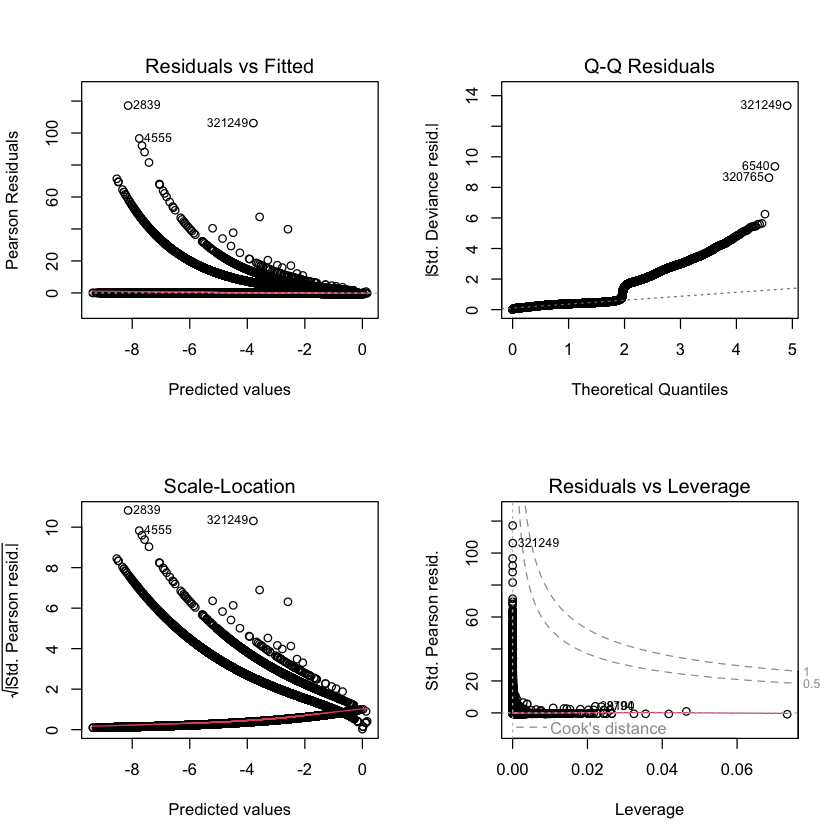

In [28]:
par(mfrow=c(2,2))
plot(glm2)

In [10]:
summary(glm2)


Call:
glm(formula = ClaimNb ~ VehPower + VehAge + DrivAge + BonusMalus + 
    VehBrand + VehGas + Density + Region + Area, family = poisson(), 
    data = m2_train, offset = log(Exposure))

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -4.7269076  0.3166401 -14.928  < 2e-16 ***
VehPower5      0.1755779  0.0203326   8.635  < 2e-16 ***
VehPower6      0.1838242  0.0203089   9.051  < 2e-16 ***
VehPower7      0.1209445  0.0200286   6.039 1.55e-09 ***
VehPower8     -0.0770517  0.0305004  -2.526 0.011529 *  
VehPower9      0.2096426  0.0223905   9.363  < 2e-16 ***
VehAge.L      -0.4822449  0.0199565 -24.165  < 2e-16 ***
VehAge.Q      -0.0177665  0.0170613  -1.041 0.297720    
VehAge.C      -0.1473929  0.0150301  -9.806  < 2e-16 ***
VehAge^4       0.0909640  0.0127178   7.153 8.52e-13 ***
DrivAge.L      0.2299728  0.0196407  11.709  < 2e-16 ***
DrivAge.Q      0.0045702  0.0159905   0.286 0.775027    
DrivAge.C     -0.2061898  0.0137015 -15.049  < 2e-16 *

The model itself doesn't show big red flags again. We are indeed still significant at all features - which is not completely absurd since we are using the same Exposure offset and a similar model structure. Let's see if on the Classifier Metrics there is any improvement


## Evaluation of Results Based on Classifier Metrics



In [8]:
glm2_pred <- predict(glm2, newdata=m2_test, type='response')
evalCut(glm2_pred, m2_test$Claim,0.059)

1994,1502
25493,38811


We achieve a slightly better TPR, whereas TNR is a bit worse, as well as slightly worse F1score. I would still choose this model at this stage given that we identify almost 100 more True Positives, than in the classifier.

Another reason to use the Poisson model is that the expected value obtained via the predict() method allows us to estimate the expected number of Claims, which will be useful after we Finish Stage 1 and 2 and integrate both models

In [9]:
summary(glm2_pred)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000089 0.017344 0.047702 0.053520 0.076865 0.840913 

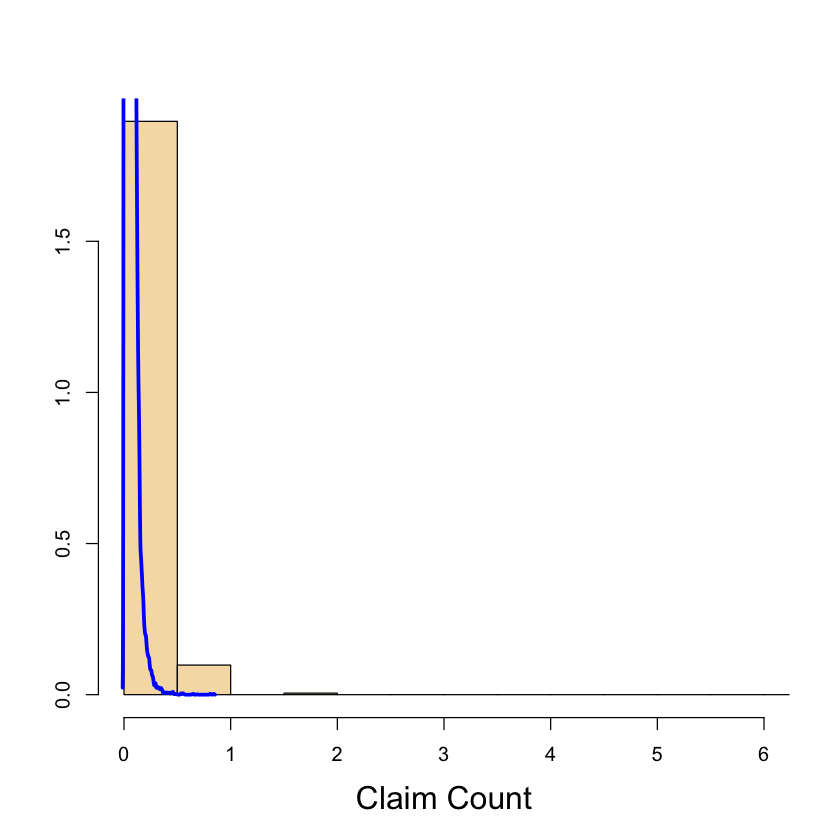

In [21]:
 hist(m2_test$ClaimNb,prob =TRUE, main = '', ylab = '', xlim =c(0, 6) , col = 'wheat', xlab = 'Claim Count', cex.lab = 1.6)
 lines(density(glm2_pred),col = 'blue', lwd = 3)

## Graphical Display of the Coefficients

In order to graphically summarise the model coefficientes we built a function that takes
the glm model and plots the exponentied coefficients (minus intercept) for the significant coefficients.



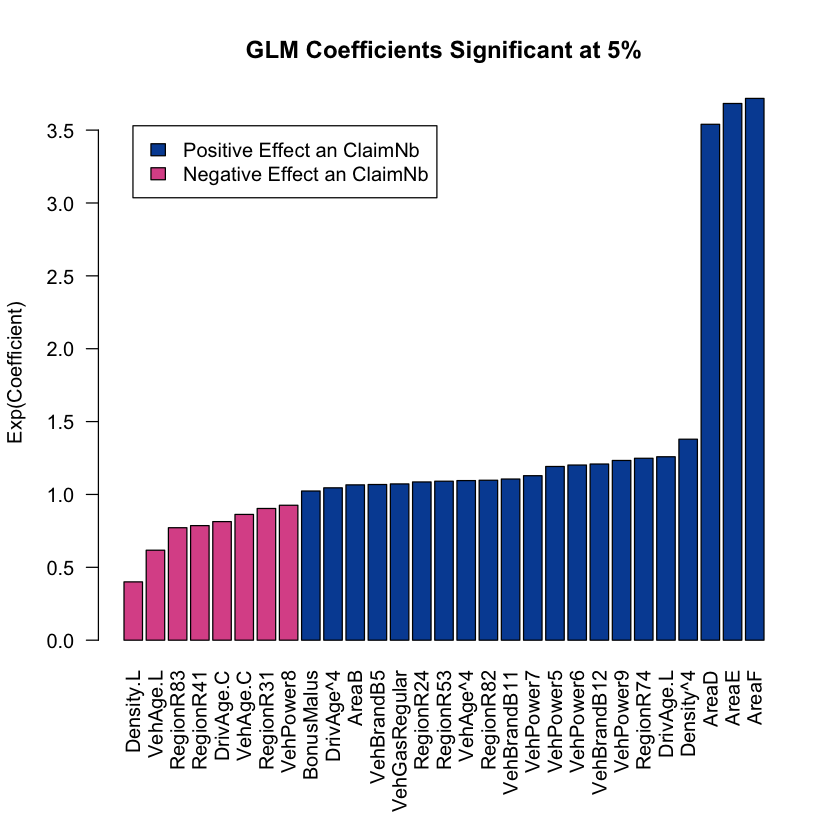

In [25]:
source('../trunk/progs/util_funcs.R')
plot_exp_coeffs(glm2,target = 'ClaimNb')

# Model Stage 2

Based on EDA we decided to try a Gamma model with log link, to take in account swekewness in the distribution of target and overdispersion

## GLM Gamma 

In [13]:
glmc1 <- glm(target ~ VehPower + VehAge + DrivAge + BonusMalus
      + VehBrand + VehGas + Density + Region + Area,
                family=Gamma(link="log"), data=cm2_train)

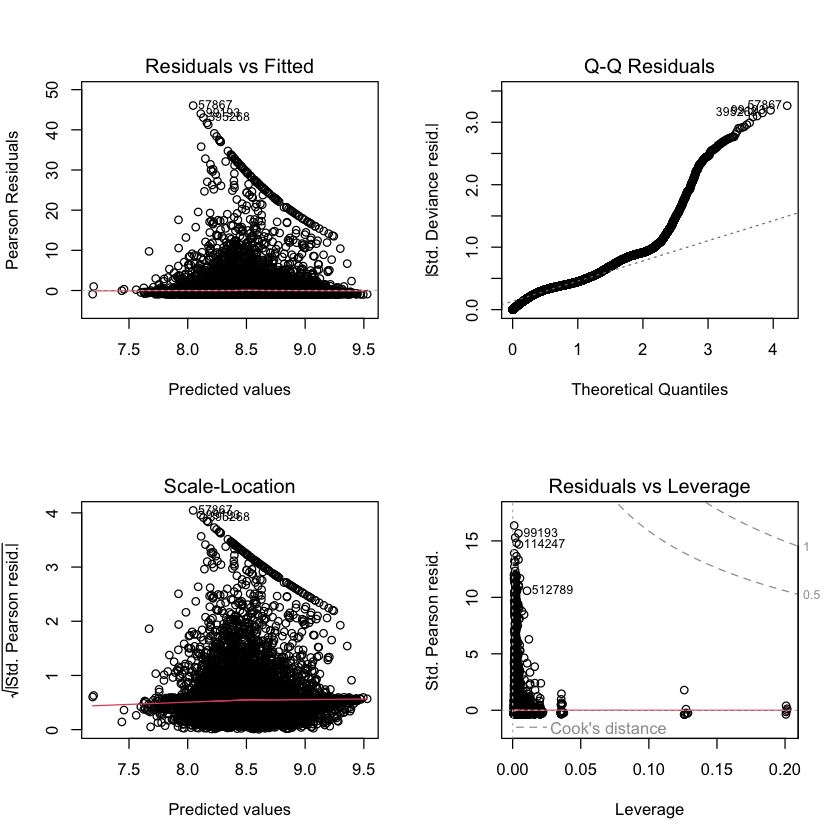

In [27]:
par(mfrow=c(2,2))
plot(glmc1)

In [14]:
summary(glmc1)


Call:
glm(formula = target ~ VehPower + VehAge + DrivAge + BonusMalus + 
    VehBrand + VehGas + Density + Region + Area, family = Gamma(link = "log"), 
    data = cm2_train)

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    8.8707128  0.9569426   9.270  < 2e-16 ***
VehPower5     -0.1038347  0.0708315  -1.466  0.14268    
VehPower6     -0.0622018  0.0695530  -0.894  0.37117    
VehPower7     -0.0380047  0.0686675  -0.553  0.57996    
VehPower8     -0.0655008  0.0983382  -0.666  0.50537    
VehPower9      0.0090656  0.0768977   0.118  0.90615    
VehAge.L       0.0611512  0.0645297   0.948  0.34332    
VehAge.Q       0.0590943  0.0556158   1.063  0.28800    
VehAge.C       0.0102185  0.0482991   0.212  0.83245    
VehAge^4       0.0190504  0.0407456   0.468  0.64011    
DrivAge.L     -0.4781567  0.0657371  -7.274 3.63e-13 ***
DrivAge.Q      0.1069907  0.0535289   1.999  0.04565 *  
DrivAge.C     -0.1059682  0.0456939  -2.319  0.02040 *  
DrivAge^4  

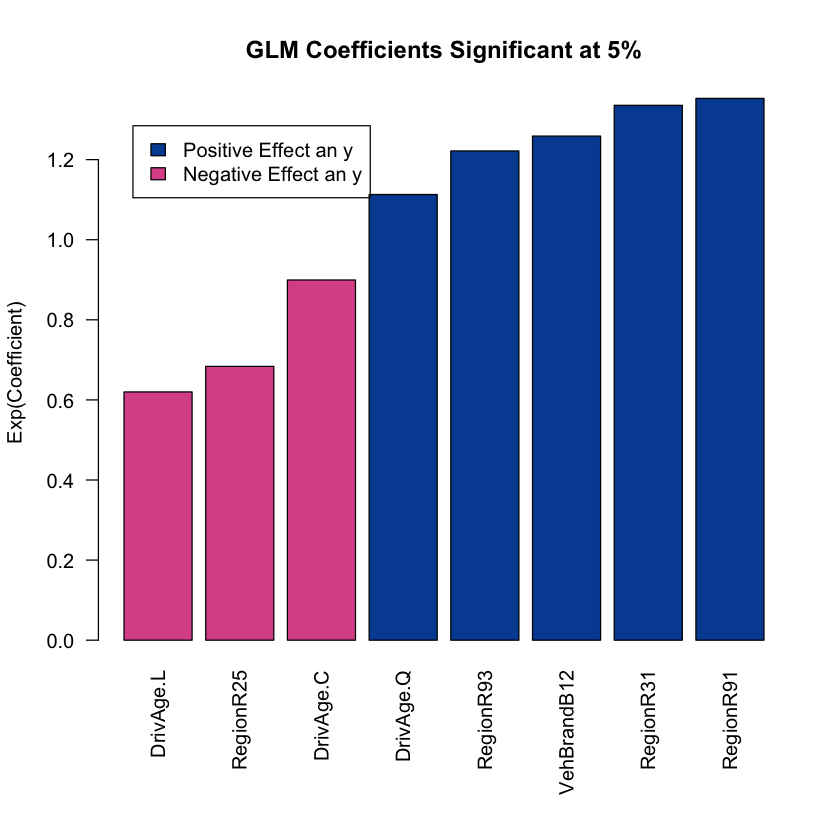

In [35]:
source('../trunk/progs/util_funcs.R')
plot_exp_coeffs(glmc1,target = 'y', dist = 't' , alpha.cutoff = 0.05)

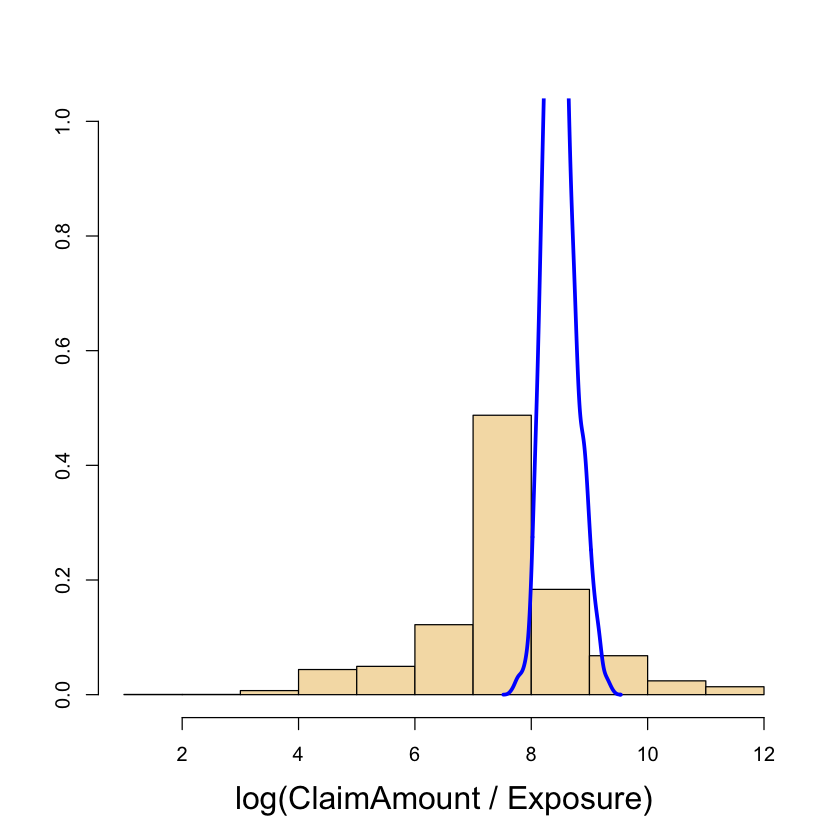

In [40]:
       glmc1_pred <- predict(glmc1, newdata=cm2_test, type="response")
        hist(log(cm2_test$target),prob =TRUE, main = '', ylim = c(0,1) , ylab = '', col = 'wheat', xlab = 'log(ClaimAmount / Exposure)', cex.lab = 1.6)
        lines(density(log(glmc1_pred)),col = 'blue', lwd = 3)

## RandomForest Regressor

In [5]:
require(ranger)
rf_model <- ranger(log(target) ~ VehPower + VehAge + DrivAge + BonusMalus
                         + VehBrand + VehGas + Density + Region + Area,
                         data=cm2_train,  num.trees = 500, importance = 'impurity')

Lade nötiges Paket: ranger



In [6]:
print(rf_model)

Ranger result

Call:
 ranger(log(target) ~ VehPower + VehAge + DrivAge + BonusMalus +      VehBrand + VehGas + Density + Region + Area, data = cm2_train,      num.trees = 500, importance = "impurity") 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      19975 
Number of independent variables:  9 
Mtry:                             3 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       1.961435 
R squared (OOB):                  -0.01891845 


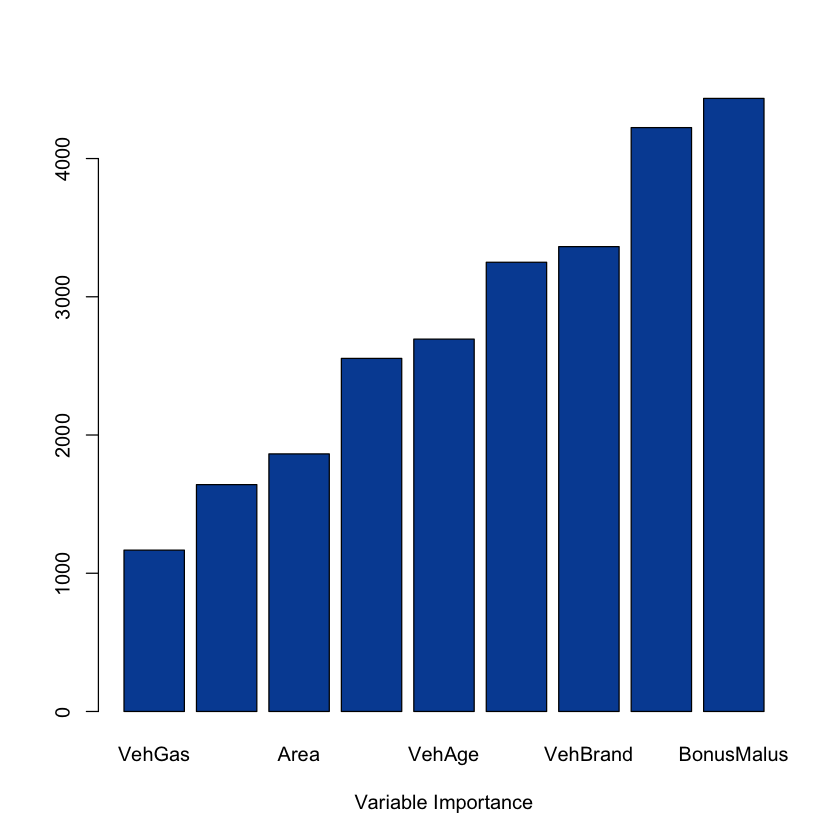

In [10]:
barplot(sort(rf_model$variable.importance), col = '#034EA2', xlab = 'Variable Importance')

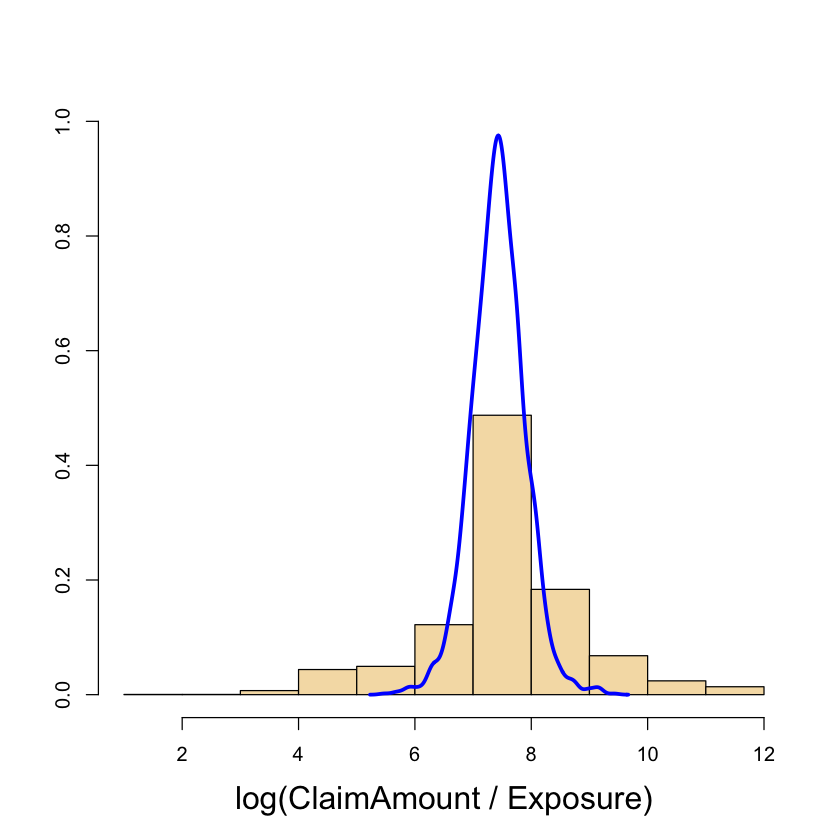

In [11]:
   rf_predictions <- exp(predict(rf_model , data=cm2_test)$predictions)
        hist(log(cm2_test$target),prob =TRUE, main = '', ylim = c(0,1) , ylab = '', col = 'wheat', xlab = 'log(ClaimAmount / Exposure)', cex.lab = 1.6)
        lines(density(log(rf_predictions)),col = 'blue', lwd = 3)

## Computing MAE and MAPE Metrics

In [15]:
library(Metrics)

# For GLM model
glm_predictions <- predict(glmc1, newdata=cm2_test, type="response")
glm_mae <- mae(cm2_test$target, glm_predictions)
glm_mape <- mape(cm2_test$target, glm_predictions)
print(paste("GLM MAE: ", glm_mae))
print(paste("GLM MAPE: ", glm_mape))

# For Random Forest model
rf_predictions <- exp(predict(rf_model , data=cm2_test)$predictions)
rf_mae <- mae(cm2_test$target, rf_predictions)
rf_mape <- mape(cm2_test$target, rf_predictions)
print(paste("Random Forest MAE: ", rf_mae))
print(paste("Random Forest MAPE: ", rf_mape))

[1] "GLM MAE:  5667.94316370145"
[1] "GLM MAPE:  6.65606684042201"
[1] "Random Forest MAE:  4237.11673306096"
[1] "Random Forest MAPE:  2.08719901946737"


# 6. Combining Stages 1 and 2

In [20]:
        # Winner Model Stage 1: Poisson Regressor (glm2)
        # Winner Model Stage 2 : Random Forest Regressor (rf_forest)

        cm2_preds_stage2_valid <- exp(predict(rf_model, data = cm2_valid)$predictions)

        # now we apply the stage 1 model here
        cm2_preds_stage1_valid <- predict(glm2, newdata=cm2_valid, type="response")


        totPredExp <- cm2_preds_stage1_valid*cm2_preds_stage2_valid
        print(sum(totPredExp))
        totExp_Real <- sum(cm2_valid$sumClaims)
        print(sum(totExp_Real))

        # We will just apply it now to the whole validation basis

        m2_stage1 <- predict(glm2, newdata = m2_valid, type = 'response')
        m2_stage2 <- exp(predict(rf_model, data = m2_valid)$predictions)

        m2_valid$final_pred <-  m2_stage1 * m2_stage2
        summary(m2_valid$final_pred)


[1] 395792.5
[1] 3965684


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.0454   28.1486   71.4239  100.4773  129.6386 2420.1609 

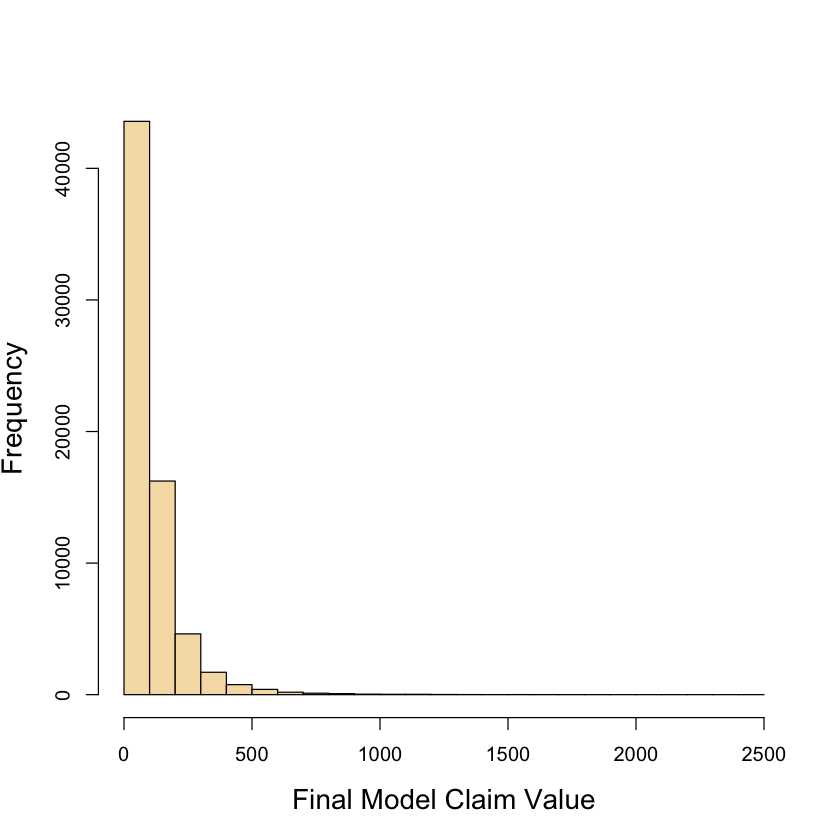

In [30]:
hist(m2_valid$final_pred, col = 'wheat', main = '', xlab = 'Final Model Claim Value', cex.lab = 1.4)

# 7. Final Evaluation of Combined Model Stages



In [32]:
        # We would like to compare total Claims on Validation
        # versus total Claims predicted by our Model

        # One challenge is that
        # for 37% of Claims there is no SumClaims! So our SumClaims is underestimated...
        # Let's to do some simple imputation
        # We will calculate mean Claim pro Claim im valid, and extrapolate it to the missing
        # claims
        sum(m2_valid$ClaimNb > 0)
        # [1] 3368
        sum(!is.na(m2_valid$sumClaims))
        # [1] 2436
        #So we need to extrapolate sumClaims for around 1000 contracts (932)

        #we can use cm2_valid for that
        mean_sumClaim_per_claim <- mean(cm2_valid$sumClaims/cm2_valid$ClaimNb)
        print(mean_sumClaim_per_claim)

        # now back to m2_valid
        m2_valid$impsumClaim <- m2_valid$ClaimNb*mean_sumClaim_per_claim

        # Now we just replace sumClaim with impsumClaim, if sumClaim is na

        m2_valid$sumClaims.ext <- ifelse(is.na(m2_valid$sumClaims), m2_valid$impsumClaim, m2_valid$sumClaims)

        # Now we can compare the total amount of Claims in Validation
        # with what our compuded model Stage1 * Stage2 would have predicted:

        print(paste('Sum of claims final model: ', sum(m2_valid$final_pred)))
        print(paste('Extrapoled sum Of claims :', sum(m2_valid$sumClaims.ext)))


[1] 3368

[1] 2436

[1] 1517.127
[1] "Sum of claims final model:  6812561.70083519"
[1] "Extrapoled sum Of claims : 5443365.83161255"


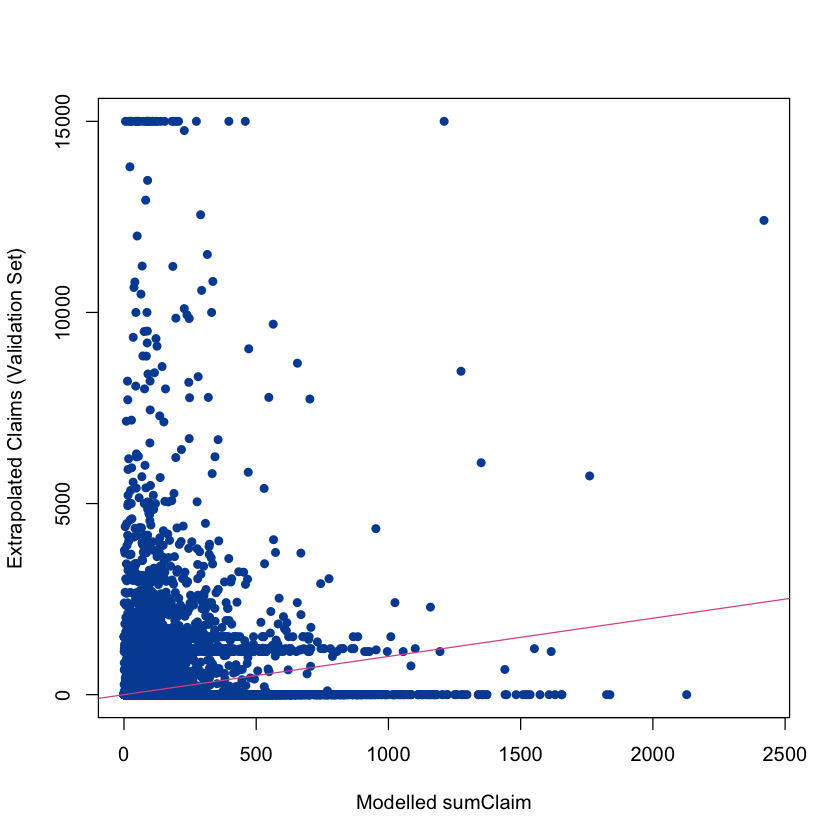

In [42]:
plot(m2_valid$sumClaims.ext ~m2_valid$final_pred, pch = 16, col = '#034EA2'
                ,xlab = 'Modelled sumClaim', ylab = 'Extrapolated Claims (Validation Set)')
    
abline(0,1, col = '#DC5797')

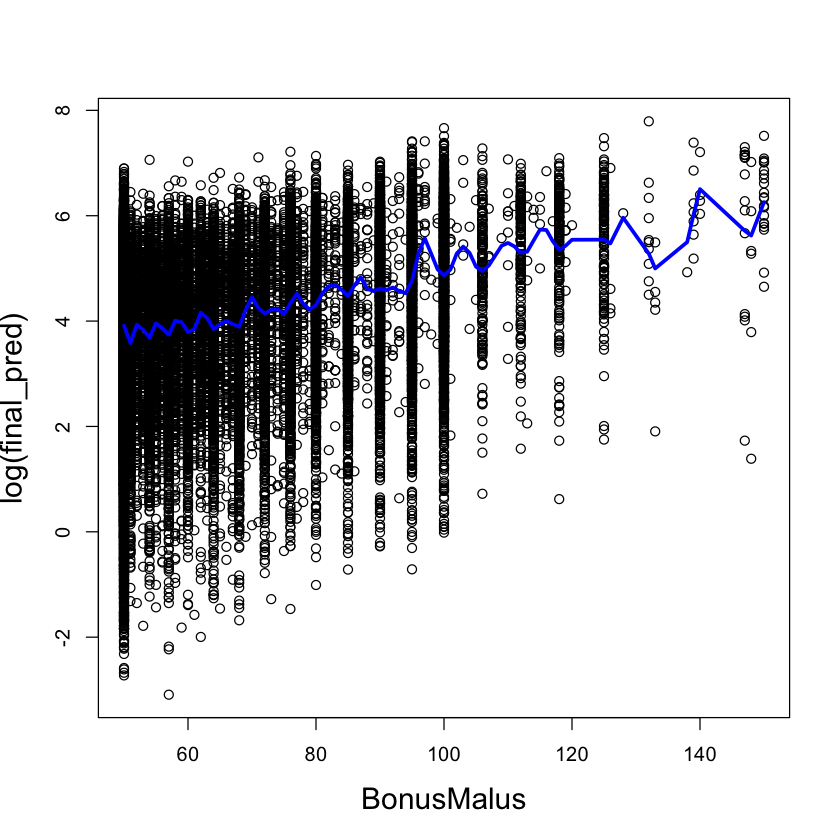

In [49]:
plot(log(m2_valid$final_pred) ~ m2_valid$BonusMalus, cex.lab = 1.5, ylab = 'log(final_pred)', xlab = 'BonusMalus')
spl1 <- smooth.spline(m2_valid$BonusMalus, log(m2_valid$final_pred))
lines(spl1, col = 'blue', lwd = 3)